In [58]:
# Final version of the water-filling in 1dspace-time.
# Get a nice looking RF for midget and parasol
# compare spatial and temporal slices to real data

In [59]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [60]:
## Parameters


NFREQ = 300 # discretization
f1 = 0 # lowest freq
f2 = 1e-3 # highest freq


## equilibrated trapezoid
N = 1 # noise level



In [61]:
X = np.linspace(f1,f2,NFREQ)
T = np.linspace(f1,f2,NFREQ)

In [62]:
## Generate spectrum



GX,GT = np.meshgrid(X[:-1],T[:-1])

# Power density
Sdensity = 1/(GX**2*GT**2)
S = np.diff(-1/X)[:,np.newaxis]*np.diff(-1/T)[:,np.newaxis].T

print(S.shape)

# Total Power
total_S = np.sum(S)

print(total_S)

(299, 299)
inf


/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in true_divide
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in true_divide


In [63]:
## Compute water filling for a range of lambdas

# range of lambdas
NLAMBDAS = 100
#lambdas = np.logspace(12,25,NLAMBDAS)
lambdas = np.logspace(0,25,NLAMBDAS)

# library of water-filling solutions for different lamdas
Ws = list()
for lambd in lambdas:
    F = np.sqrt(N/(lambd*Sdensity)) - N/Sdensity #Filter Magnitue Square per mode
    W = S*F #Total water per block
    W[W<0] = 0 
    
    #plt.figure()
    #plt.imshow(np.sqrt(W), cmap = 'seismic', vmin = -np.max(np.sqrt(W)), vmax =  np.max(np.sqrt(W)),origin='lower')
    #plt.colorbar()
    
    Ws.append(W.T)

Ws = np.array(Ws).T
Ws.shape


/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in multiply
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in less


(299, 299, 100)

In [64]:
## Sum across temporal frequencies (we don't need those)

# volume of each voxel
Nf = np.diff(X)[:,np.newaxis]*np.diff(T)[:,np.newaxis].T

# Precompute variance per mode explained for all lambdas
colVarExpl = np.sum(S[:,:,np.newaxis]*Ws/(Ws+N*Nf[:,:,np.newaxis]),axis =0)
# cumulative variance explained (it's going to fasten up things in the grid search)
cumVarExpl = np.vstack((np.zeros(NLAMBDAS),np.cumsum(colVarExpl,axis = 0)))

# Water filling array for all modes and lamdas
colWs = np.sum(Ws,axis = 0)
# Cumulative Water filling array (it's going to fasten up things in the grid search)
cumWs = np.vstack((np.zeros(NLAMBDAS),np.cumsum(colWs,axis = 0)))

print(colVarExpl.shape, cumVarExpl.shape,colWs.shape, cumWs.shape)

(299, 100) (300, 100) (299, 100) (300, 100)


In [65]:
## Iterate over all possible decompositions between N cell types to find the best one



# Number of types
NTYPES = 2

## Create grid for grid search

# Create grid for grid search over strides for different types
STEP = 1 # step of the grid search
strides = np.arange(0,NFREQ,STEP)
NSTRIDES = len(strides)
g = [strides for i in range(NTYPES)]
g = np.meshgrid(*g)
stride_grid = np.array([gi.ravel() for gi in g])

# Create grid for grid serach over lambdas to find best objective
g = [np.arange(0,NLAMBDAS) for i in range(NTYPES)]
g = np.meshgrid(*g)
lambda_grid = np.array([gi.flatten() for gi in g])

print(stride_grid.shape,lambda_grid.shape)

recs = list()
strides = list()

# Total firing rate threshold ('number of spikes')
NSPIKES = 1


GRID = np.zeros(NTYPES)
NITER =  stride_grid.shape[1]

EXPL = np.nan* np.zeros(NITER)
OBJ = np.zeros(NITER)
L1s = np.zeros(NITER)
LAMB = np.zeros((NITER,NTYPES))

# start grid search over strides of each type
for i in range(NITER):
    lims = stride_grid[:,i] # end limit of the modes covered by each type

    if np.all(np.diff(lims)>0) and lims[0]>0: # if all limits are in an 
        #increasing order (avoid switching types) 


        lims2 = [0,*lims]

        #print(lims)

        all_varsExpl = list()
        all_l1s = list()
        for typ in range(NTYPES):

            # Variance explained for each lambda
            varExp = cumVarExpl[lims2[typ+1]] - cumVarExpl[lims2[typ]]

            # Budget of cells for each type
            budgetCells = X[lims2[typ+1]] - X[lims2[typ]]

            # penalty
            l1_penalty = np.sqrt(budgetCells*(cumWs[lims2[typ+1]]- cumWs[lims2[typ]]))


            all_varsExpl.append(varExp)
            all_l1s.append(l1_penalty)


        all_varsExpl = np.array(all_varsExpl)
        total_varsExpl = sum([all_varsExpl[ityp,lambda_grid[ityp]] for ityp in range(NTYPES)])

        all_l1s = np.array(all_l1s)
        total_l1s = sum([all_l1s[ityp,lambda_grid[ityp]] for ityp in range(NTYPES)])

        # objective for each lambda
        objective = total_varsExpl - 1e60 * np.maximum(total_l1s - NSPIKES, 0)   

        best_lambdas_ind = np.argmax(objective)

        best_lambdas = lambda_grid[:,best_lambdas_ind]


        #if 0 in best_lambdas:
        #    print('warning lambda LOWER bound reached',lims)
        #if NLAMBDAS-1 in best_lambdas:
        #    print('warning lambda UPPER bound reached')

        best_objective = objective[best_lambdas_ind]

        best_varExp = total_varsExpl[best_lambdas_ind]
        
        best_L1 = total_l1s[best_lambdas_ind]

        EXPL[i] = best_varExp
        LAMB[i,:] = best_lambdas        
        OBJ[i] = best_objective
        L1s[i] = best_L1 

        #print(best_objective)
        #print(best_varExp)

        #STRIDES[i,:] = best_strides

        #print(lims,best_lambdas,best_objective)

        #print(sumObjs.shape,lambda_grid.shape)


iter_max = np.argmax(OBJ)

rec = (np.sum(S) - EXPL[iter_max])/np.sum(S)*100
st = stride_grid[:,iter_max]

recs.append(rec)
strides.append(st)
#print(np.argmax(EXPL))
print('RECONSTRUCTION ERROR: ',rec,'%')
print('BEST NCELLS:', stride_grid[:,iter_max])
print('BEST LAMBDAS:', LAMB[iter_max])
print('OBJ:', OBJ[iter_max])
print('')

RECS = (np.sum(S) - EXPL)/np.sum(S)*100

(2, 90000) (2, 10000)
RECONSTRUCTION ERROR:  nan %
BEST NCELLS: [1 2]
BEST LAMBDAS: [ 0.  0.]
OBJ: nan



In [66]:
## lambda indices, stride indices

print(LAMB[iter_max], stride_grid[:,iter_max])

(lambda_parasol, lambda_midget) = LAMB[iter_max]
(lim_parasol, lim_midget) = stride_grid[:,iter_max]

[ 0.  0.] [1 2]


/Applications/Pineapple.app/Contents/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/Applications/Pineapple.app/Contents/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Applications/Pineapple.app/Contents/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


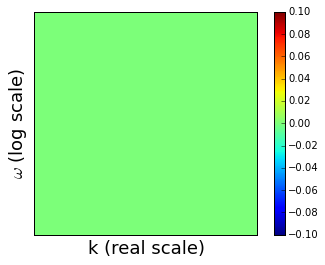

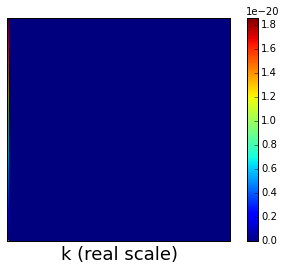

In [22]:
## LOOK at RF in Fourier space

F_parasol = Ws[:,:,lambda_parasol]/Sdensity
F_parasol[:,lim_parasol:] = 0

F_midget = Ws[:,:,lambda_midget]/Sdensity
F_midget[:,:lim_parasol] = 0
F_midget[:,lim_midget:] = 0


#fig, axs = plt.subplots(1,2,figsize = (8,4))
plt.figure()
plt.xticks([])
plt.yticks([])
#plt.contour(S, np.logspace(5,10,10), linewidths = 2, linestyles = 'solid', colors = 'k')
plt.imshow(F_parasol,origin='lower')
plt.xlabel('k (real scale)', fontsize = 18)
plt.ylabel(r'$\omega$ (log scale)', fontsize = 18)
plt.colorbar()

plt.savefig('RF_parasol.png',bbox_inches = 'tight', pad_inches = .1)

plt.figure()
plt.xticks([])
plt.yticks([])
#plt.contour(S, np.logspace(5,10,10), linewidths = 2, linestyles = 'solid', colors = 'k')
plt.imshow(F_midget,origin='lower')
plt.xlabel('k (real scale)', fontsize = 18)
plt.colorbar()

plt.savefig('RF_midget.png',bbox_inches = 'tight', pad_inches = .1)


#plt.imshow(np.sqrt(Fk), cmap = 'bwr', vmin = -np.max(Fk), vmax =  np.max(Fk),origin='lower')
#plt.colorbar()





In [11]:
F_midget

array([[  0.00000000e+00,   9.34305490e-23,   2.48529562e-22, ...,
          5.48757089e-20,   5.50617111e-20,   5.52477132e-20],
       [  0.00000000e+00,   5.26404616e-18,   1.40016661e-17, ...,
          3.03063006e-15,   3.04069438e-15,   3.05075728e-15],
       [  0.00000000e+00,   1.40016661e-17,   3.72400810e-17, ...,
          7.89835779e-15,   7.92402252e-15,   7.94967976e-15],
       ..., 
       [  0.00000000e+00,   3.03063006e-15,   7.89835779e-15, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   3.04069438e-15,   7.92402252e-15, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   3.05075728e-15,   7.94967976e-15, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [10]:
F_parasol.shape

(299, 299)

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log


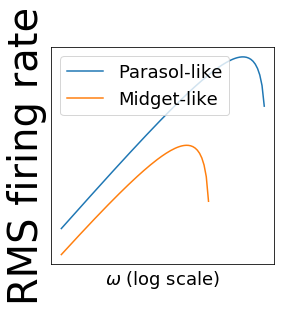

In [11]:
y = F_parasol[:,lim_parasol-1]

#y = np.concatenate((y,[1e-50]))

plt.figure(figsize = (4,4))
plt.plot(np.log(T[80:-1])/np.log(10)+4.6,np.log(y[80:])/np.log(10))
plt.plot(np.log(T[80:-1])/np.log(10)+4.6,np.log(F_midget[80:,lim_parasol+1])/np.log(10))
plt.xlabel(r'$\omega$ (log scale)',fontsize = 18)
plt.ylabel(r'Sensitivity ($F^2$)',fontsize = 18)

plt.ylabel(r'RMS firing rate',fontsize = 40)
plt.xticks([])
plt.yticks([])
plt.legend(['Parasol-like','Midget-like'],fontsize = 18, loc = 'upper left')

plt.savefig('Temporal_RF.png',bbox_inches = 'tight', pad_inches = .1)


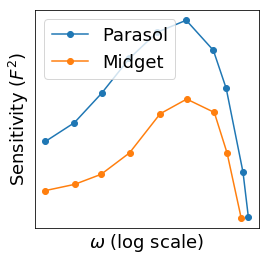

In [12]:
import pandas as pd
df=pd.read_csv('midget_RF.csv', sep=',',header=None)
M = df.values
df=pd.read_csv('parasol_RF.csv', sep=',',header=None)
P = df.values

plt.figure(figsize = (4,4))

plt.plot(np.log(P[:,0])/np.log(10),np.log(P[:,1])/np.log(10),'-o')
plt.plot(np.log(M[:,0])/np.log(10),np.log(M[:,1])/np.log(10),'-o')
plt.xticks([])
plt.yticks([])
plt.xlabel(r'$\omega$ (log scale)',fontsize = 18)
plt.ylabel(r'Sensitivity ($F^2$)',fontsize = 18)

plt.legend(['Parasol','Midget'],fontsize = 18 , loc = 'upper left')

In [13]:
## lambda indices, stride indices

print(LAMB[iter_max], stride_grid[:,iter_max])

lambda_single = LAMB[iter_max]
lim_single = stride_grid[:,iter_max]

[ 24.  26.] [ 89 160]


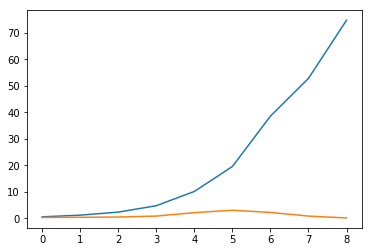

In [14]:
import csv


# Read CSV file
with open('midget_RF.csv', 'r') as fp:
    reader = csv.reader(fp, delimiter=',', quotechar='"')
    # next(reader, None)  # skip the headers
    M = np.array([row for row in reader])
    
with open('parasol_RF.csv', 'r') as fp:
    reader = csv.reader(fp, delimiter=',', quotechar='"')
    # next(reader, None)  # skip the headers
    P = np.array([row for row in reader])
    
    
plt.plot(M)

In [15]:
## LOOK at RF in Fourier space

F_single = Ws[:,:,lambda_parasol]/Sdensity
F_single[:,lim_single:] = 0



#fig, axs = plt.subplots(1,2,figsize = (8,4))
plt.figure()
plt.xticks([])
plt.yticks([])
plt.contour(S, np.logspace(5,10,10), linewidths = 2, linestyles = 'solid', colors = 'k')
plt.imshow(np.log(F_single),origin='lower')
plt.xlabel('k (log scale)', fontsize = 18)
plt.ylabel(r'$\omega$ (log scale)', fontsize = 18)
plt.colorbar()

plt.savefig('RF_single.png',bbox_inches = 'tight', pad_inches = .1)

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


IndexError: failed to coerce slice entry of type numpy.ndarray to integer

In [ ]:

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
#X = np.arange(-5, 5, 0.25)
#Y = np.arange(-5, 5, 0.25)
#X, Y = np.meshgrid(X, Y)
#R = np.sqrt(X**2 + Y**2)
#Z = np.sin(R)

Z = np.log(F_parasol)

#Z[Z<-80] = -80

# Plot the surface.
surf = ax.plot_wireframe(GX, GT, Z, rstride=5, cstride=5)


# Customize the z axis.
ax.set_xlim(0, 0.002)
ax.set_ylim(0, 0.002)

#ax.view_init(90, 40)
#ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [ ]:
v = np.logspace(-1,1,100)

# 2.1 Hz
kc = 108.5
rc = 0.031
tc = 169.4
xc = 0.008
ks = 46.8
rs = 0.199
ts = -22.2
xs = 0.021

L1 = kc*rc*np.sqrt(np.pi)*np.exp(-(np.pi*rc*v)**2+1j*(np.pi/180)*(tc-360*xc*v)) 
+ks*rs*np.sqrt(np.pi)*np.exp(-(np.pi*rs*v)**2+1j*(np.pi/180)*(ts-360*xs*v))

# 8.5 Hz
kc = 158.3
rc = 0.033
tc = 40.5
xc = 0.011
ks = 101.4
rs = 0.232
ts = -162
xs = 0.029

L2 = kc*rc*np.sqrt(np.pi)*np.exp(-(np.pi*rc*v)**2+1j*(np.pi/180)*(tc-360*xc*v)) 
+ks*rs*np.sqrt(np.pi)*np.exp(-(np.pi*rs*v)**2+1j*(np.pi/180)*(ts-360*xs*v))

# 16.9 Hz
kc = 113
rc = 0.031
tc = -124.9
xc = 0.012
ks = 72.9
rs = 0.455
ts = 19.7
xs = -0.042

L3 = kc*rc*np.sqrt(np.pi)*np.exp(-(np.pi*rc*v)**2+1j*(np.pi/180)*(tc-360*xc*v)) 
+ks*rs*np.sqrt(np.pi)*np.exp(-(np.pi*rs*v)**2+1j*(np.pi/180)*(ts-360*xs*v))


plt.plot(np.log(np.abs(L1)**2))
plt.plot(np.log(np.abs(L2)**2))
plt.plot(np.log(np.abs(L3)**2))

In [ ]:
plt.plot(np.log(F_parasol[10]))
plt.plot(np.log(F_parasol[11]))
plt.plot(np.log(F_parasol[12]))



In [ ]:
1+i

In [ ]:
plt.plot(np.log(F_parasol[0]))

In [ ]:
plt.plot(np.log(F_midget[0]))

In [ ]:
#